<a href="https://colab.research.google.com/github/TwaitesJosh/Concha/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Report

Joshua Twaites

### Disclaimer

Most of the code in this report is has been modified for ease of understanding, it may not actually run, luckilly it shouldn't need to. As that is what the github code is for.

Also, , I cannot spell, and google colab doesn't have a spell check. I apologise for any typos.

All working code can be found on https://github.com/TwaitesJosh/Concha

##Summary

tl;dr 

Everything I did in brief. More details below.

###Goal
Build a classifier that can predict {500k, 1k, 3k , 8k} from features of {2k, 4k, 6k}.

### Data exploration: 
*	About 700,000 files had a ‘missing’ variable (either ‘**’ or values which were not multiples of 5).
*	Most common class was {2k: 0, 4k:0, 6k:0}, creating a huge imbalance in data.
*	Despite {2k,4k,6k} being integers, they can be viewed as categorical/ordinal as only 22 possible values exist (as only multiples of 5 are acceptable). This means there are only 10,648 possible unique inputs for the classifer.
*	When including right/left we have around 4,000,000 examples


###Model building: 
*	Given the imbalance, missing data and categorical inputs, this task is particularly suited to K-Nearest Neighbours (KNN), which ignores imbalance, missing data (if done properly) and allows for categorical inputs.
*	KNN is not suited to such large data sets, however, as there are only 10,648 possible unique values for the features we can just build the model on these unique values (using eager memorisation).
* I used K=300, with the addendum that I add all people whose distance is equal to the 300th furthest person, as the feature values are discrete, lots of people have the same distances.
*	To speed up prediction we can precompute all 10,648 inputs and their corresponding outputs.


### Evaluation:
* I optimised hyperparameters against R2-score and weighted kappa statistic. I assumed accuracy was not the focus, as it is better to predict {0,0,0,0} than {100,100,100,100} for a correct output of {5,5,5,5}, whereas accuracy rates these two equally. R2-score averaged around 0.70-0.75, which was better than a random forest regressor I used as a comparison.



### Optional tasks:
*	The API was created using flask and uploaded to ec2.aws. The address is:

`ec2-18-118-160-157.us-east-2.compute.amazonaws.com`

*	For a given input x, I found the optimal fourth variable by finding the closest 300 people. I computed the gini-impurity on the data from these 300 with the variables {500k, 1k, 3k, 8k} and found which variable minimised the value gini value. I used this as the extra variable for classification. As before, to ensure I do not have to recompute this every time, I computed this for every 10,648 possible inputs, although as I took a fourth input there are 234,256 possible inputs, representing a large but not too large data base (40Mb).


### Key points/Additions:
*	The inputs to all of the models are not error checked, if you do not put a variable that is a multiple of 5, or do not put in a list of 3/4 numbers, they will not work. I did not have time to fix this.
*	 The API website is not fantastic, I assume you are judging me based on the performance of the model not my web-design skills.
*	All models in the github simply read the inputs from the pre-computed csv, the actual code to create them is in this report.
*	The command line interfaces only accept a single input at once. The models can easily handle any size input as they are just pandas merge and lookup functions, but to handle user input, I kept the CLI’s as single input.


## CLI
I have saved everything in github and created a docker image. The docker image represents the CLI.

The commands to access it are:


` docker pull twaitesjosh/concha-main `


` docker run -i twaitesjosh/concha-main `

The -i tag is becuase it is interactive.



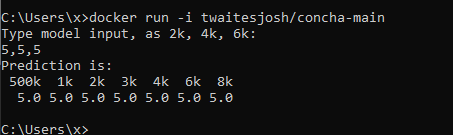


In [2]:
import pandas as pd
import numpy as np
import itertools
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.neighbors import NearestNeighbors as NN


## Goal
The goal of the take home task was to predict the values of {500k, 1k, 3k, 8k} from inputs of {2k, 4k, 6k}, and to provide a CLI to allow non-tech savvy users to interact with it. Checking with Leslie said that docker containers were acceptable. I doubt non-tech savvy people can use docker, but there you go.


Optional goals were to create an API and to suggest a fourth variable to allow the user to improve performance.


### Take away
Classic ML problem using 3 inputs for a multi-class output.

## Data exploration

The data has 2,900,000-ish rows, with the following columns

In [7]:
drive.mount('/content/drive')
tab = pd.read_csv('/content/drive/My Drive/g.csv', low_memory=False)
print(tab.shape)
print(tab.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2944670, 21)
Index(['test_date', 'nid', 'L500k', 'L1k', 'L2k', 'L3k', 'L4k', 'L6k', 'L8k',
       'R500k', 'R1k', 'R2k', 'R3k', 'R4k', 'R6k', 'R8k', 'gender', 'naics',
       'age_group', 'region', 'NAICS_descr'],
      dtype='object')


As I need to be able to predict the {500k, 1k, 3k, 8k} with just {2k, 4k, 6k} I can drop all of the other rows from my data. While there are surely insights that can be gained from gender and age range, in these problems I don’t have access to that information, so I can ignore it. Additionally, I can treat the left and right values as entirely separate according to the problem sheet.

In the data the features have a diverse range of potential values, however checking with Leslie tells me that only the values that are multiples of 5 are actually correct. Due to this constraint in feature values, it is possible to view them as categoric values (or at least ordinal values). As there are three features each with 22 possible values (ranging from -5 to 100), I actually only have 10648 (22^3) possible unique inputs to my model. Obviously, there are more rows than this, meaning feature values repeat, unfortunately their {500k, 1k, 3k, 8k} values do not necessarily repeat. Therefore, it is not possible to have a perfect classification (it rarely is, to be honest).

In [4]:
def clean_data(tab, keep_nans = True):
  # Remove all the non-numeric rows
  tab_numeric = tab[['L500k', 'L1k', 'L2k', 'L3k', 'L4k', 'L6k', 'L8k', 'R500k', 'R1k', 'R2k', 'R3k', 'R4k', 'R6k', 'R8k']]
  # Force everything to either number or NaN
  tab_numeric = tab_numeric.apply(pd.to_numeric, errors='coerce')


  YL = tab_numeric[['L500k', 'L1k', 'L2k', 'L3k', 'L4k', 'L6k', 'L8k']].dropna()
  YR = tab_numeric[['R500k', 'R1k', 'R2k', 'R3k', 'R4k', 'R6k', 'R8k']].dropna()

  # Remove everything that sin't a mutliple of 5 (as this is an error)
  YR=YR[(YR%5==0).sum(1) ==7] 
  YL=YL[(YL%5==0).sum(1) ==7]

  # Match names
  YL = YL.rename(columns={'L500k': '500k', 'L1k': '1k','L2k': '2k','L3k': '3k','L4k': '4k','L6k': '6k','L8k': '8k'})
  YR = YR.rename(columns={'R500k': '500k', 'R1k': '1k','R2k': '2k','R3k': '3k','R4k': '4k','R6k': '6k','R8k': '8k'})
  
  # Stack on top of each other
  Y = pd.concat([YL,YR],ignore_index=True)

  # If we want to keep the NA values, repeat the process with them
  if keep_nans:
    is_NaN = tab_numeric.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = tab_numeric[row_has_NaN]

    Nan_tab = rows_with_NaN[np.sum(np.logical_or(rows_with_NaN%5==0, rows_with_NaN.isna()), 1)==14]
    Nan_tabL = Nan_tab[['L500k', 'L1k', 'L2k', 'L3k', 'L4k', 'L6k', 'L8k']]
    Nan_tabR = Nan_tab[['R500k', 'R1k', 'R2k', 'R3k', 'R4k', 'R6k', 'R8k']]
    Nan_tabL = Nan_tabL.rename(columns={'L500k': '500k', 'L1k': '1k','L2k': '2k','L3k': '3k','L4k': '4k','L6k': '6k','L8k': '8k'})
    Nan_tabR = Nan_tabR.rename(columns={'R500k': '500k', 'R1k': '1k','R2k': '2k','R3k': '3k','R4k': '4k','R6k': '6k','R8k': '8k'})
    Y_Nan = pd.concat([Nan_tabL, Nan_tabR],ignore_index=True)

    Y = pd.concat([Y,Y_Nan],ignore_index=True)
  
  return Y

Investigating the class balances shows that by far the majority class is {500k:0, 1k:0, 3k:0, 8k:0}, e.g. no hearing problems at all, which is unsurprising.

In [14]:
Y = clean_data(tab, keep_nans = False)
X = Y[['2k','4k','6k']]
np.sum(np.all(Y[['2k','4k','6k']] == [0,0,0], 1))

83004

Around 1,500,000 rows had some data missing, representing about 30%. Obviously, this needs to be dealt with, however removing it entirely means throwing away a lot of data.

In [18]:
Y_nan = clean_data(tab, keep_nans = True)
print(Y_nan.shape[0] - Y.shape[0])

1576562


### Take away 
I have 3 categorical (ordinal) features and 10648 possible unique different inputs; the data set is hugely imbalanced, and I have a lot of missing data. 

In [ ]:
possible_X_values = np.array(list(itertools.product(5*np.arange(-1, 21), repeat = 3)))

## Model:

Because of the missing data, class imbalance and the limited potential inputs to the classifier (10648 potential inputs) I choose a K-Nearest neighbour’s approach. Where for a given input X, the predicted classes were the average (mean) of the closest 300 people. When I take the mean, I can ignore the missing value in rows, so I get to use the non-missing data from rows that do contain missing data, which partially mitigates the missing data issue.


As the feature values were discrete, the distances were also discrete, and therefore in picking the closest 300 was difficult. So instead, I iterated through the potential differences (low to high) until I had at least 300 neighbours. So, if I have 299 rows who have a distance of less than 5 from input X, and 4000 people are 5.2 away. I will end up examining 4299 neighbours not just 300.


Class imbalance doesn’t really impact KNN (it does, but not in this case) so I can ignore it.



One of the issues with KNN is it is very slow, both in the training and testing. However, I can mitigate this by using the fact that there are only 10648 possible inputs to the model, so I can train only on these unique values and apply my results to the entire data set. This allows me to train the entire model in under 30 seconds. A similar approach can be taken for the prediction step. As there are only 10648 possible inputs to the model, there are only 10648 possible outputs to the model, I can pre-compute these and store them as a data frame. This technique is known as eager memoisaton, it is contextually similar to dynamic programming but done in reverse, so all the memorisation is done first. When I predict a value, I just have to look it up in the data frame, which is much faster than a KNN and takes much less storage space. This is why all of the model.py’s in the github are just pandas look-up functions.


In [22]:
class model:

	def __init__(self):
		# All possible X_values as a set of tuples
		self.possible_X_values = np.array(list(itertools.product(5 * np.arange(-1, 21), repeat=3)))
		self.set_of_all_possible_x = set([tuple(x) for x in self.possible_X_values])
		
		self.group_indexes = None
		self.nn = None
		self.memorised_data = None

	def fit(self, X_train, y_train):
    # Collapse y-train into unique values of 2k, 4k, 6k and create a set of where they occour
		groups = y_train.groupby(['2k', '4k', '6k'])
		self.group_indexes = groups.indices
		set_of_all_X_train = set(self.group_indexes)

    # Identify the unique values of 2k, 4k, 6k in X and create a KNN classifer on them
		self.x_unique = X_train.groupby(['2k', '4k', '6k']).size().reset_index().rename(columns={0: 'count'})
		self.nn = NN(metric='minkowski', p=3)
		self.nn.fit(self.x_unique[['2k', '4k', '6k']])
		
		# make sure group_indices has all possible x values
		unused_keys = self.set_of_all_possible_x.difference(set_of_all_X_train)
		for k in unused_keys:
			self.group_indexes[k] = []

		self.memorised_data = self.eager_memoisation(y_train)


	def get_Y_train_standard(self, i, y_train):
   # Find all neigbors within 50 (an arbitrarly large value)
		ten_n = self.nn.radius_neighbors(i, 50)
   # Find the unique distances in sorted order, makes use of the fact the unique also sorts that data
		uniq = np.unique((ten_n[0][0])) 
		total = 0
		indexes = []
    # for each distance, find the people in Y-train who re that far away
		for d in uniq:
      # Add indexes of people who are distance d away from input row
			train_loc = ten_n[1][0][ten_n[0][0] == d]
      # Keep total amount of people who are being used as neigbors
			total += np.sum(self.x_unique['count'].values[train_loc])
			indexes = np.concatenate((indexes, train_loc))
     # if 300 or more neighbors, break
			if total > 300:
				break
		m = indexes
		l = []
    # Find all people in Y_train who are within distance of row I
		for j in m:
			l = np.concatenate((self.group_indexes[tuple(self.x_unique.iloc[int(j)].values[:3])], l))
		l = np.array(l, dtype=np.int)
    # Table of all people within distance of row I
		mode = y_train.iloc[l][['500k', '1k', '3k', '8k']]
		return mode

	def get_Y_lab(self, i, y_train):
   # Just get the mean of the table and make sure it is a multiple of 5
		tab = self.get_Y_train_standard(i, y_train)
		return np.round(tab.mean(0) / 5) * 5

	def eager_memoisation(self, y_train):
   # for all unique values of x, create corresponding y_values
		y_unique_labs = pd.DataFrame(self.possible_X_values, columns=['2k', '4k', '6k']).apply(
			lambda x: self.get_Y_lab([x], y_train), 1)
		y_unique_labs = pd.DataFrame(y_unique_labs.values.tolist(), index=y_unique_labs.index, columns=['500k', '1k', '3k', '8k']) 
		labeled_x_data = pd.DataFrame(self.possible_X_values, columns=['2k', '4k', '6k']).join(y_unique_labs)
		return labeled_x_data

	def predict(self, X_test):
   # Look up X_test in the memorised data
   # Merge does tend to unsort the data, so the resorting by the index is required
		y_pred = X_test.reset_index().merge(self.memorised_data, left_on=['2k', '4k', '6k'], right_on=['2k', '4k', '6k'], how='left').sort_index()
		y_pred = y_pred.drop(columns=['index'])
		return y_pred[['500k', '1k','2k','3k','4k','6k', '8k']]

## Evaluation

### Metrics
The main metric I optimised in this work was R_2 score. I operated under the assumption that a prediction of {5,5,5,5} should be considered closer to a target of {0,0,0,0} than {100,100,100,100}, therefore accuracy was not a good metric to use. R_2 allowed for this notion of closeness along with being very quick to compute and allowing for the multi-output of the model.
I also utilised weighted Kappa, which is a metric that measures the degree of disagreement between the two raters (the predictor and the truth, in this case), the higher the disagreement the higher the weight (so prediciting {5,5,5,5} is 10 times worse than predicting {50,50,50,50} if the truth is {0,0,0,0}).


### Optimisation:
In general, changing the hyperparameters of the model has a neglible influence on the performance of the model, with the main source of error being that there is not a direct mapping of input to output, as the same input can have different outputs in the training data. Although it was found that adding the missing data improved the performance by about 0.02-0.05. Changing the metric and the value of K (number of neighbors) has limited influence on CV score.


### Comparison:
I created a very simple Random Forest Regressor to act as a ‘standard approach’ as RF’s are also relatively immune to class imbalance and perform well in almost every circumstance. This obtained an R_2 score of 0.7 without any optimisation. This was the standard that I compared my classifier to.


### Overfitting:
In general, KNN can be safe from overfitting as long as you use a large enough value for K, 300 is quite large. Additionally, optimising over cross-validated performance helps mitigate the impact of overfitting. I used 10-fold CV, making sure that the left and right data from people were always in the same groups to mitigate any intra-person impacts on the data. As I didn't have time to study the indepth impacts of this.


## Command line interface

I created docker repositories for the task, so in theory you can just pull these and run them.


The commands to access it are:


` docker pull twaitesjosh/concha-main `


` docker run -i twaitesjosh/concha-main `


It is worth noting that you require the -i tag on docker run, this is becuase it is interactive.

In [ ]:
m = model()
m.fit(X_train, y_train)
# Tab is the look-up table that the github models read
tab = m.memorised_data


## Optional task 1:
Create an API

The API is created using flask. I am hosting it on an AWS ec2 server.

`ec2-18-118-160-157.us-east-2.compute.amazonaws.com`

This is an example curl request:


` curl -X POST ec2-18-118-160-157.us-east-2.compute.amazonaws.com:80/predict -H "Content-Type: application/json" -d "[5,30,5]" `


It is worth noting, that linux and windows get really ansty if you mix up ' and " in a curl request. I lost 6 hours of my life fixing that issue.

The website itself is not great, obviously I am not a web designer. The functionality of the API is identical to the Concha-main. It won't take multiple inputs and doesn't error check the inputs.

## Optional task 2:
Allow users to add a fourth variable.


With this task I once again made use of eager memoisation. For each of the 10648 possible inputs, I identified the K-nearest neighbours, as above. I then computed the GINI impurity on the features {500k, 1k, 3k, 8k} to see which of the one of the potential new features best split the data. The feature with the lowest GINI was select as the ‘extra’ variable for the input. Then for each potential value of that input I computed the closet 300 neighbours and identified the mean value.


As I am now using 4 variables my potential unique values number are 234,256 which is a little large for a csv, however it only takes up about 30Mb, so it is fine to be mounted on a server. The computation of the final lookup table took around 1-hour.


The container that runs this is avaiable through docker, named


The commands to access it are:


` docker pull twaitesjosh/concha-opt2 `


` docker run -i twaitesjosh/concha-opt2 `


It is worth noting that you require the -i tag on docker run, this is becuase it is interactive.


In [ ]:
# Computes the GINI coeff of a column
def gini_coefficient(x):
	x = x.values
	diffsum = 0
	for i, xi in enumerate(x[:-1], 1):
		diffsum += np.sum(np.abs(xi - x[i:]))
	return diffsum / (len(x)**2 * np.mean(x))

# This is added to the model class, allows it to find the minimum GINI value
def find_fourth_variable(self, i, y_train):
  tab = self.get_Y_train_standard(i, y_train)
  return tab.dropna().apply(gini_coefficient, 0).idxmin()
  
  


In [ ]:
m = model()
m.fit(X_train, y_train)
# Create the memeorised datm then compute the optimal extra value
tab_4th_vari = m.memorised_data[['2k','4k','6k']].apply(lambda x: m.find_fourth_variable([x], y_train), 1)
tab = m.memorised_data[['2k','4k','6k']]
tab['extra row'] = tab_4th_vari

# Create all possible unique combinations of {2k,4k,6k and the optional variable}
possible_X_values = np.array(list(itertools.product(5*np.arange(-1, 21), repeat = 4)))
tab_4 = pd.DataFrame(possible_X_values, columns = ['2k', '4k', '6k', 'extra row value'])
tab_4['extra row'] = np.repeat(tab['extra row'].values, 22)

I ran each extra row value {'500k, '1k', '3k','8k'} seperately, so I didn't have to redefine the KNN algorithm each time. I then merged all of the tables together, to create a csv with all possible input values which I can use as a lookup table in the github code.

In [ ]:
tab_500k = tab[tab['extra row']=='500k']
variable = '500k'
groups = y_train.groupby(['2k', '4k', '6k',variable])
group_indexes =  groups.indices
    
x_unique = y_train.groupby(['2k','4k', '6k', variable]).size().reset_index().rename(columns={0:'count'})
nn = NN(metric='minkowski', p=3)
nn.fit(x_unique[['2k','4k', '6k', variable]])
  

store = tab_500k.apply(lambda x: find_4th_metric(x[['2k', '4k', '6k', 'extra row value']]), 1)

def find_4th_metric(row):

  ten_n = nn.radius_neighbors([row], 80)
  
  uniq = np.unique((ten_n[0][0]))
  total=0
  indexes = []
  for i in uniq:
    train_loc = ten_n[1][0][ten_n[0][0]==i]
    total += np.sum(x_unique['count'].values[train_loc])
    indexes = np.concatenate((indexes, train_loc)) 
    if total>300:
      break
  m = indexes
  l = []
  for j in m:
    l = np.concatenate((group_indexes[tuple(x_unique.iloc[int(j)].values[:4])], l))
  l = np.array(l, dtype = np.int)

  mode = y_train.iloc[l][['500k','1k', '3k','8k']]

  mean =  np.round(mode.mean(0)/5)*5
  return mean



In [ ]:
# Save/load table for each of the possible optional variables
tab_8k = pd.read_csv('8k.csv')
tab_1k = pd.read_csv('1k.csv')
tab_3k = pd.read_csv('3k.csv')
tab_500k = pd.read_csv('500k.csv')

tab_8k_complete = tr[tr['extra row']=='8k'].merge(tab_8k, left_index=True, right_on= 'Unnamed: 0')
tab_1k_complete = tr[tr['extra row']=='1k'].merge(tab_1k, left_index=True, right_on= 'Unnamed: 0')
tab_3k_complete = tr[tr['extra row']=='3k'].merge(tab_3k, left_index=True, right_on= 'Unnamed: 0')
tab_500k_complete = tr[tr['extra row']=='500k'].merge(tab_500k, left_index=True, right_on= 'Unnamed: 0')

# Merge them all together, and final csv is the csv that the classifer can load
t1 = pd.concat([tab_1k_complete,tab_3k_complete], 0)
t2 = pd.concat([tab_500k_complete, tab_8k_complete], 0)
t3 = pd.concat([t1, t2], 0)
t3.to_csv('final.csv')